<a href="https://colab.research.google.com/github/Gaurangg1404/learning-AI-ML/blob/main/Copy_of_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun 26 09:54:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-26 09:54:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-26 09:54:22 (83.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test"

--2024-06-26 09:54:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  15.0MB/s    in 1m 41s  

2024-06-26 09:56:14 (15.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 direc

In [6]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)


In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),

], name="data_augmentation")

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 2s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 156s 610ms/step - loss: 3.3686 - accuracy: 0.2762 - val_loss: 2.4866 - val_accuracy: 0.4608
Epoch 2/5
237/237 [==============================] - 106s 444ms/step - loss: 2.1933 - accuracy: 0.5031 - val_loss: 2.0132 - val_accuracy: 0.5217
Epoch 3/5
237/237 [==============================] - 89s 376ms/step - loss: 1.8257 - accuracy: 0.5679 - val_loss: 1.9246 - val_accuracy: 0.5151
Epoch 4/5
237/237 [==============================] - 82s 344ms/step - loss: 1.5996 - accuracy: 0.6148 - val_loss: 1.8044 - val_accuracy: 0.5469
Epoch 5/5
237/237 [==============================] - 76s 317ms/step - loss: 1.4477 - accuracy: 0.6411 - val_loss: 1.7727 - val_accuracy: 0.5448


In [12]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 56s 71ms/step - loss: 1.5714 - accuracy: 0.5874


[1.571378231048584, 0.5873663425445557]

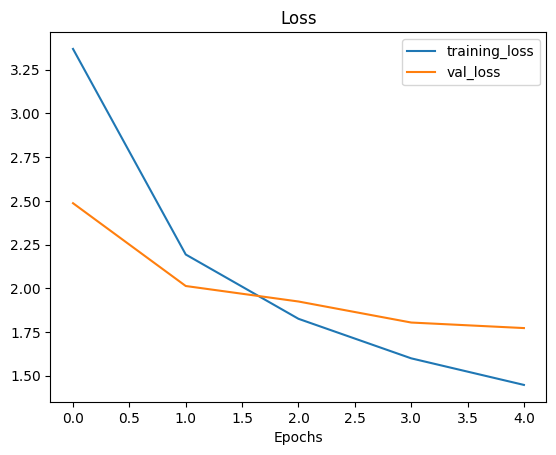

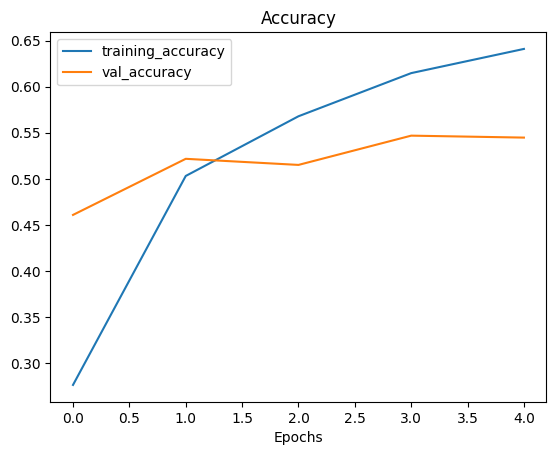

In [13]:
plot_loss_curves(history_all_classes_10_percent)

In [14]:

base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable=False


In [15]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])


In [16]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [18]:
fine_tune_epochs=10

history_all_classes_10_percent_fine_tune= model.fit(train_data_all_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15*len(test_data)),
                                                    initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 79s 296ms/step - loss: 1.4848 - accuracy: 0.5983 - val_loss: 1.8714 - val_accuracy: 0.5082
Epoch 6/10
237/237 [==============================] - 68s 285ms/step - loss: 1.0876 - accuracy: 0.7014 - val_loss: 1.9198 - val_accuracy: 0.5074
Epoch 7/10
237/237 [==============================] - 63s 265ms/step - loss: 0.8315 - accuracy: 0.7655 - val_loss: 2.0291 - val_accuracy: 0.4976
Epoch 8/10
237/237 [==============================] - 57s 239ms/step - loss: 0.6508 - accuracy: 0.8190 - val_loss: 1.8566 - val_accuracy: 0.5479
Epoch 9/10
237/237 [==============================] - 63s 263ms/step - loss: 0.5025 - accuracy: 0.8539 - val_loss: 2.1604 - val_accuracy: 0.5199
Epoch 10/10
237/237 [==============================] - 57s 236ms/step - loss: 0.4289 - accuracy: 0.8731 - val_loss: 2.4426 - val_accuracy: 0.4677


In [19]:
all_classes_10_percent_fine_tune_results =  model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 55s 69ms/step - loss: 2.0353 - accuracy: 0.5439


[2.035306215286255, 0.5439208149909973]

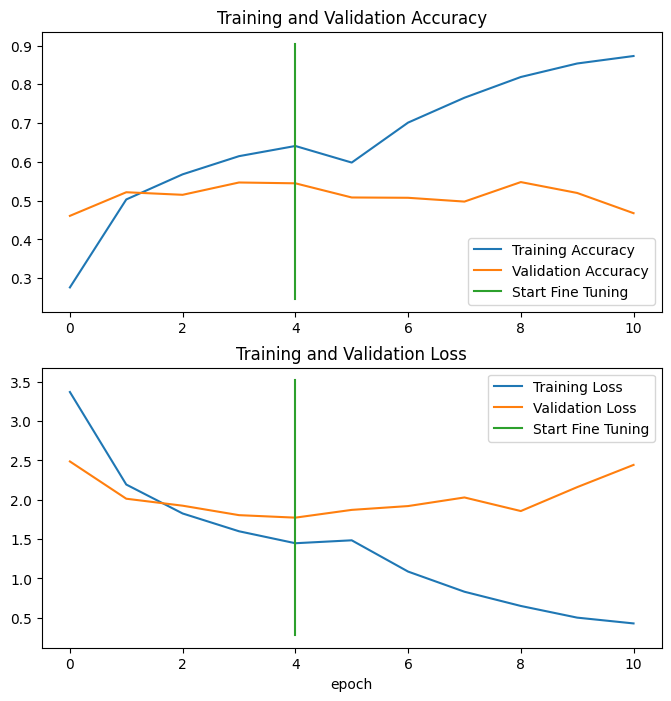

In [20]:
compare_historys(original_history=history_all_classes_10_percent,
                new_history=history_all_classes_10_percent_fine_tune,
                initial_epochs=5)

In [21]:
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_big_dog_model")

In [22]:
loaded_model=tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_big_dog_model")

In [23]:
loaded_model_results=loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 58s 72ms/step - loss: 2.0353 - accuracy: 0.5439


[2.035306215286255, 0.5439208149909973]

In [24]:
all_classes_10_percent_fine_tune_results

[2.035306215286255, 0.5439208149909973]

In [25]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-06-26 10:17:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  9.28MB/s    in 5.2s    

2024-06-26 10:17:26 (8.64 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [26]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [27]:
result_downloaded_model=model.evaluate(test_data)
result_downloaded_model

790/790 [==============================] - 54s 69ms/step - loss: 2.0353 - accuracy: 0.5439


[2.035306215286255, 0.5439208149909973]

In [28]:
preds_probs = model.predict(test_data, verbose=1)


790/790 [==============================] - 60s 74ms/step


In [29]:
len(test_data)

790

In [30]:
preds_probs[0],len(preds_probs[0]),sum(preds_probs[0])

(array([4.69670266e-01, 2.57543917e-07, 5.77684417e-02, 1.35767675e-10,
        2.08154365e-08, 3.42386471e-07, 9.49081550e-06, 1.28525945e-08,
        5.26735373e-03, 1.68260010e-06, 1.20852604e-07, 9.30798336e-08,
        2.01890874e-03, 5.12671461e-09, 5.92987708e-05, 2.44466122e-04,
        3.75573507e-07, 4.41152079e-05, 6.44525187e-03, 7.85871009e-07,
        3.34877404e-04, 1.97204354e-05, 1.09493488e-03, 4.25918806e-05,
        1.72569096e-04, 7.05348657e-06, 2.52324344e-06, 1.00522348e-05,
        2.26909757e-01, 1.08981032e-04, 2.05486643e-07, 1.80287225e-05,
        7.45934085e-05, 2.71504803e-07, 1.82636082e-02, 3.04659480e-08,
        3.02378709e-07, 2.45888205e-05, 2.32172588e-05, 4.67449318e-05,
        3.30628623e-04, 7.57541391e-04, 1.50637907e-05, 4.83003532e-07,
        1.81224561e-06, 2.49532150e-06, 5.21895381e-05, 4.12425408e-07,
        3.55858974e-05, 6.63333992e-03, 2.80264521e-06, 1.09956397e-06,
        1.07314683e-01, 6.15707075e-04, 2.09106020e-06, 1.855797

In [31]:
print(f"Number of prediction probabilities for sample0:{len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0:{preds_probs[0].argmax()} ")

Number of prediction probabilities for sample0:101
What prediction probability sample 0 looks like: 
 [4.69670266e-01 2.57543917e-07 5.77684417e-02 1.35767675e-10
 2.08154365e-08 3.42386471e-07 9.49081550e-06 1.28525945e-08
 5.26735373e-03 1.68260010e-06 1.20852604e-07 9.30798336e-08
 2.01890874e-03 5.12671461e-09 5.92987708e-05 2.44466122e-04
 3.75573507e-07 4.41152079e-05 6.44525187e-03 7.85871009e-07
 3.34877404e-04 1.97204354e-05 1.09493488e-03 4.25918806e-05
 1.72569096e-04 7.05348657e-06 2.52324344e-06 1.00522348e-05
 2.26909757e-01 1.08981032e-04 2.05486643e-07 1.80287225e-05
 7.45934085e-05 2.71504803e-07 1.82636082e-02 3.04659480e-08
 3.02378709e-07 2.45888205e-05 2.32172588e-05 4.67449318e-05
 3.30628623e-04 7.57541391e-04 1.50637907e-05 4.83003532e-07
 1.81224561e-06 2.49532150e-06 5.21895381e-05 4.12425408e-07
 3.55858974e-05 6.63333992e-03 2.80264521e-06 1.09956397e-06
 1.07314683e-01 6.15707075e-04 2.09106020e-06 1.85579702e-03
 1.98699255e-03 1.14658487e-03 3.42873856e-0

In [32]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [33]:
pred_classes=preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0, 17,  8,  8,  8, 29, 46,  8, 41])

In [34]:
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

0.543920792079208

In [36]:
import numpy as np
np.isclose(result_downloaded_model[1], sklearn_accuracy)


True

In [37]:
from helper_functions import make_confusion_matrix

In [38]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()



  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [39]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [40]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.21      0.24      0.23       250
           1       0.65      0.57      0.61       250
           2       0.67      0.57      0.62       250
           3       0.80      0.46      0.58       250
           4       0.75      0.22      0.34       250
           5       0.57      0.21      0.31       250
           6       0.64      0.80      0.71       250
           7       0.89      0.66      0.76       250
           8       0.12      0.73      0.20       250
           9       0.74      0.31      0.44       250
          10       0.70      0.37      0.48       250
          11       0.89      0.50      0.64       250
          12       0.50      0.61      0.55       250
          13       0.50      0.56      0.53       250
          14       0.76      0.21      0.33       250
          15       0.41      0.27      0.33       250
          16       0.72      0.46      0.57       250
          17       0.37    

In [42]:
classification_report_dict = classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict


{'0': {'precision': 0.21107266435986158,
  'recall': 0.244,
  'f1-score': 0.2263450834879406,
  'support': 250},
 '1': {'precision': 0.6470588235294118,
  'recall': 0.572,
  'f1-score': 0.6072186836518046,
  'support': 250},
 '2': {'precision': 0.6745283018867925,
  'recall': 0.572,
  'f1-score': 0.619047619047619,
  'support': 250},
 '3': {'precision': 0.7986111111111112,
  'recall': 0.46,
  'f1-score': 0.5837563451776651,
  'support': 250},
 '4': {'precision': 0.7466666666666667,
  'recall': 0.224,
  'f1-score': 0.3446153846153846,
  'support': 250},
 '5': {'precision': 0.5698924731182796,
  'recall': 0.212,
  'f1-score': 0.30903790087463556,
  'support': 250},
 '6': {'precision': 0.6401273885350318,
  'recall': 0.804,
  'f1-score': 0.7127659574468085,
  'support': 250},
 '7': {'precision': 0.8924731182795699,
  'recall': 0.664,
  'f1-score': 0.7614678899082569,
  'support': 250},
 '8': {'precision': 0.1191879502292076,
  'recall': 0.728,
  'f1-score': 0.20483961733258302,
  'support

In [43]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [44]:
classification_report_dict["99"]["f1-score"]

0.35833333333333334

In [45]:
class_f1_scores = {}

for k,v in classification_report_dict.items():
  if k=="accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]]=v["f1-score"]

class_f1_scores


{'apple_pie': 0.2263450834879406,
 'baby_back_ribs': 0.6072186836518046,
 'baklava': 0.619047619047619,
 'beef_carpaccio': 0.5837563451776651,
 'beef_tartare': 0.3446153846153846,
 'beet_salad': 0.30903790087463556,
 'beignets': 0.7127659574468085,
 'bibimbap': 0.7614678899082569,
 'bread_pudding': 0.20483961733258302,
 'breakfast_burrito': 0.43943661971830983,
 'bruschetta': 0.4829396325459317,
 'caesar_salad': 0.635897435897436,
 'cannoli': 0.5517241379310345,
 'caprese_salad': 0.5303030303030303,
 'carrot_cake': 0.33125,
 'ceviche': 0.3252427184466019,
 'cheese_plate': 0.5658536585365854,
 'cheesecake': 0.4029304029304029,
 'chicken_curry': 0.49824561403508766,
 'chicken_quesadilla': 0.6183368869936035,
 'chicken_wings': 0.6028985507246376,
 'chocolate_cake': 0.4854700854700854,
 'chocolate_mousse': 0.28258488499452356,
 'churros': 0.7525562372188139,
 'clam_chowder': 0.7596566523605149,
 'club_sandwich': 0.5057471264367817,
 'crab_cakes': 0.35014836795252224,
 'creme_brulee': 0.719

In [46]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [47]:
f1_scores

class_names  f1-score
33         edamame  0.958904
75             pho  0.868687
63        macarons  0.852679
65         mussels  0.840404
86         sashimi  0.824034
..             ...       ...
82         ravioli  0.223837
47         gnocchi  0.222222
50  grilled_salmon  0.216028
59         lasagna  0.208754
8    bread_pudding  0.204840

[101 rows x 2 columns]

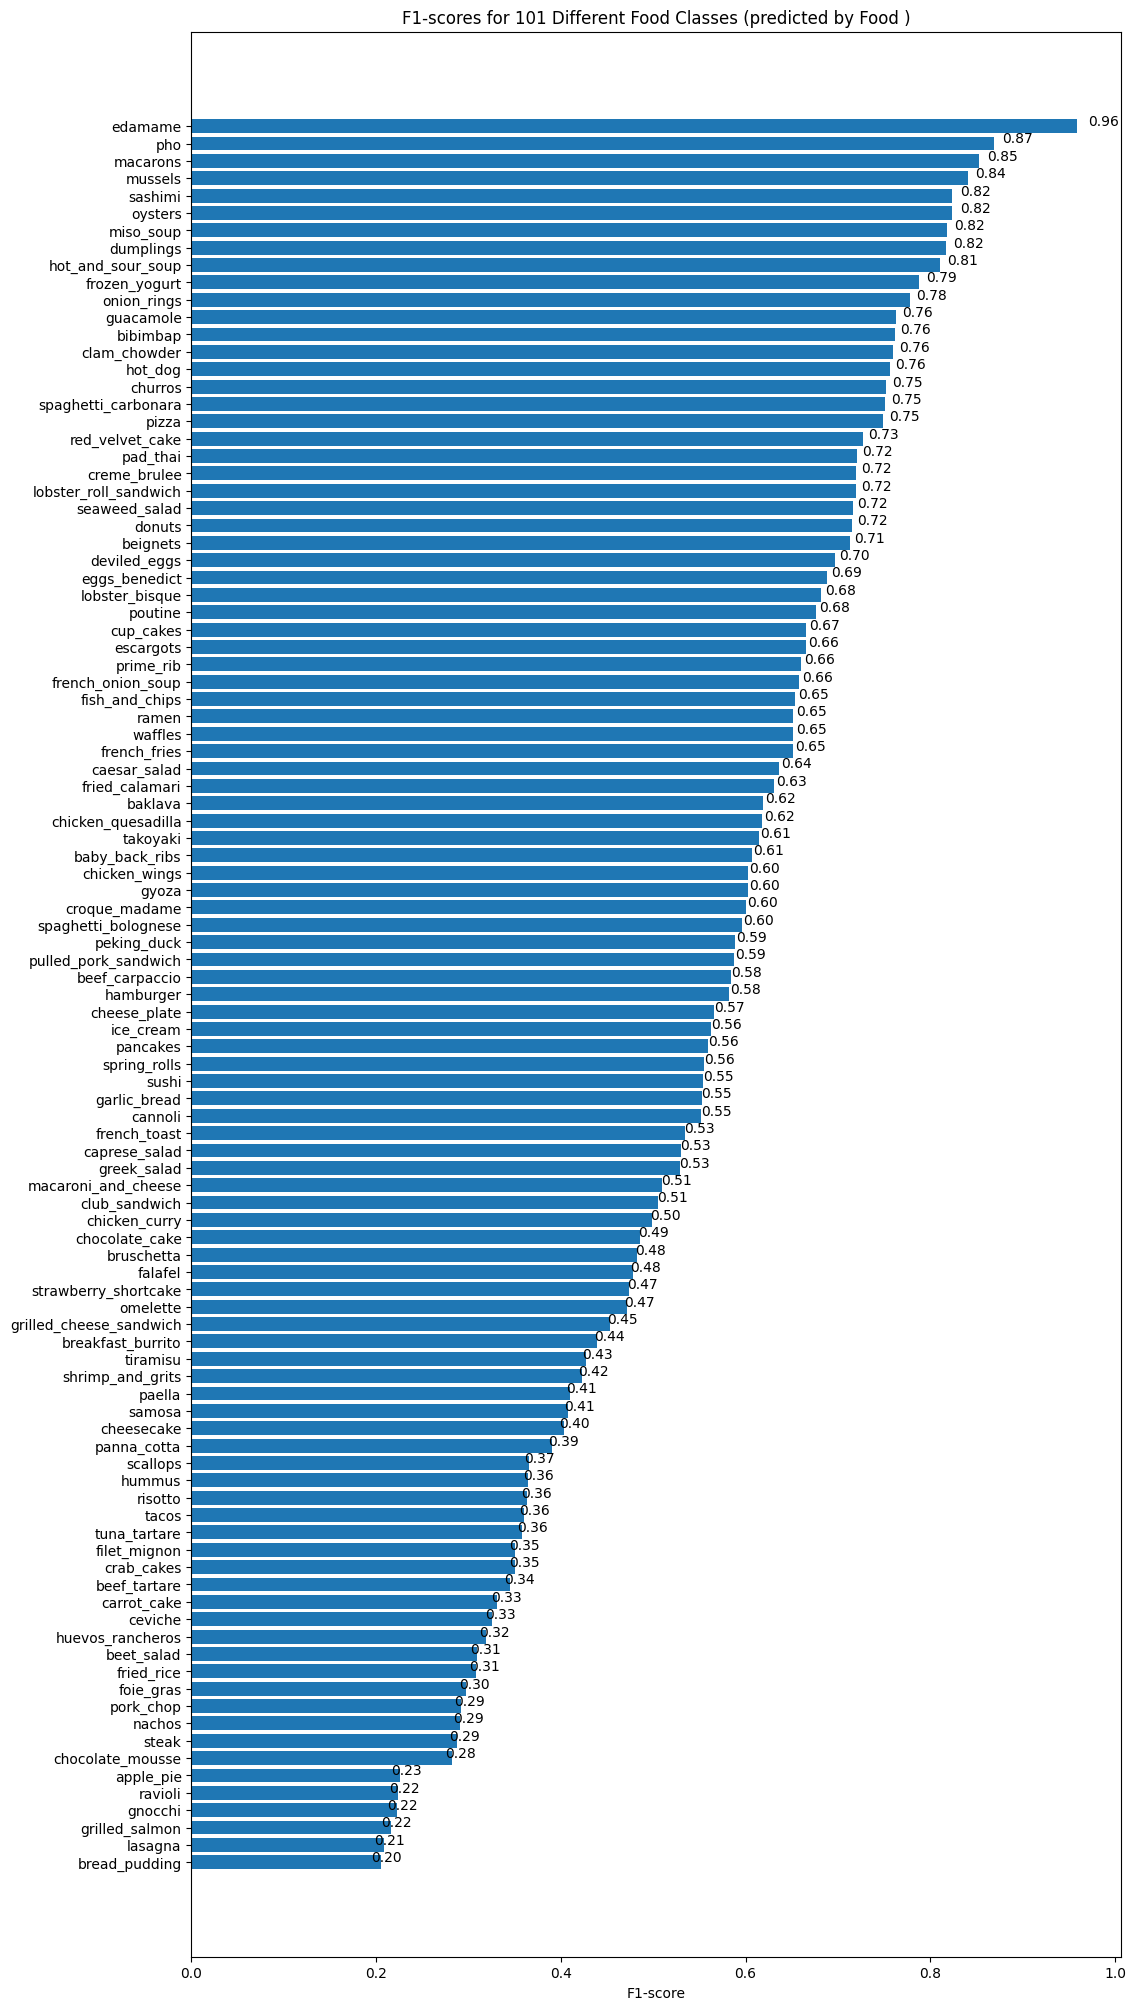

In [48]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food )")
ax.invert_yaxis();


def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)



In [49]:
pred_classes

array([  0,   0,  17, ..., 100,   8,   8])

In [50]:
def load_and_prep_image(filename, img_shape=224,scale=True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img,channels=3)
  img = tf.image.resize(img,[img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img


In [51]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[preds_probs.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} 101_food_classes_10_percent/testpaella/3397449.jpg; No such file or directory [Op:ReadFile]

<Figure size 1700x1000 with 0 Axes>

1/1 [==============================] - 4s 4s/step


TypeError: unsupported operand type(s) for /: 'Image' and 'float'

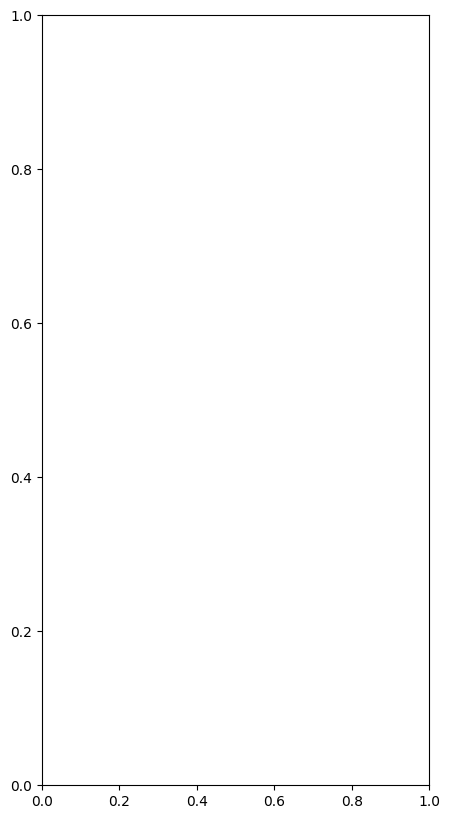

In [52]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

def load_and_prep_image(filepath, scale=True):
    # Load image from filepath
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=(224, 224))

    # Optionally scale pixel values to [0, 1]
    if scale:
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    return img

# Example function to process image
def process_image(filepath, model, class_names):
    try:
        # Load the image and make predictions
        img = load_and_prep_image(filepath, scale=False)  # Don't scale images for EfficientNet predictions
        pred_prob = model.predict(tf.expand_dims(img, axis=0))  # Model accepts tensors of shape [None, 224, 224, 3]
        pred_class = class_names[pred_prob.argmax()]  # Find the predicted class

        return pred_class, pred_prob[0][pred_prob.argmax()]  # Return predicted class and confidence score
    except Exception as e:
        print(f"Error processing image {filepath}: {e}")
        return None, None  # Return None if an error occurs

# Example usage to plot random images and their predictions
plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from a random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(os.path.join(test_dir, class_name)))
    filepath = os.path.join(test_dir, class_name, filename)

    # Load and process the image
    pred_class, pred_prob = process_image(filepath, model, class_names)

    if pred_class is not None and pred_prob is not None:
        # Load the image for plotting
        img = load_and_prep_image(filepath, scale=False)

        # Plot the image and prediction
        plt.subplot(1, 3, i+1)
        plt.imshow(img / 255.)

        # Determine title color based on correct or incorrect prediction
        title_color = "g" if class_name == pred_class else "r"

        plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob:.2f}", color=title_color)
        plt.axis(False)

plt.tight_layout()
plt.show()


In [53]:
import random
random.choice(class_names)

'ice_cream'

In [54]:

filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [55]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":[max(probs) for probs in preds_probs],
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0      17   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.469670        apple_pie        apple_pie  
1   0.977866        apple_pie        apple_pie  
2   0.290807        apple_pie       cheesecake  
3   0.614582        apple_pie    bread_pudding  
4   0.886501        apple_pie    bread_pudding

In [56]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0      17   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.469670        apple_pie        apple_pie          True  
1   0.977866        apple_pie        apple_pie          True  
2   0.290807        apple_pie       cheesecake         False  
3   0.614582        apple_pie    bread_pudding         False  
4   0.886501        apple_pie    bread_pudding         False

In [57]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)


img_path  y_true  y_pred  \
134    b'101_food_classes_10_percent/test/apple_pie/2...       0       2   
8794   b'101_food_classes_10_percent/test/escargots/1...      35      41   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
10690  b'101_food_classes_10_percent/test/french_toas...      42       6   
15893  b'101_food_classes_10_percent/test/macarons/29...      63       6   
7858   b'101_food_classes_10_percent/test/donuts/2564...      31       6   
1591   b'101_food_classes_10_percent/test/beignets/21...       6      85   
722    b'101_food_classes_10_percent/test/baklava/640...       2      85   
22684  b'101_food_classes_10_percent/test/spaghetti_b...      90      91   
23241  b'101_food_classes_10_percent/test/spring_roll...      92      85   
17908  b'101_food_classes_10_percent/test/paella/3192...      71      65   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
120    b'101_food_classes_10_percent/test/apple_pie/2...       0       2   
2663   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
12854  b'101_food_classes_10_percent/test/guacamole/2...      51      64   
5420   b'101_food_classes_10_percent/test/chocolate_c...      21      22   
17825  b'101_food_classes_10_percent/test/paella/1877...      71      65   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf     y_true_classname       y_pred_classname  pred_correct  
134     0.999996            apple_pie                baklava         False  
8794    0.999980            escargots      french_onion_soup         False  
17855   0.999975               paella                mussels         False  
10690   0.999974         french_toast               beignets         False  
15893   0.999957             macarons               beignets         False  
7858    0.999927               donuts               beignets         False  
1591    0.999898             beignets                 samosa         False  
722     0.999893              baklava                 samosa         False  
22684   0.999889  spaghetti_bolognese    spaghetti_carbonara         False  
23241   0.999858         spring_rolls                 samosa         False  
17908   0.999842               paella                mussels         False  
11642   0.999812         garlic_bread             bruschetta         False  
10880   0.999803       fried_calamari            onion_rings         False  
10854   0.999799       fried_calamari            onion_rings         False  
120     0.999789            apple_pie                baklava         False  
2663    0.999747           bruschetta  lobster_roll_sandwich         False  
12854   0.999744            guacamole              miso_soup         False  
5420    0.999665       chocolate_cake       chocolate_mousse         False  
17825   0.999642               paella                mussels         False  
10847   0.999637       fried_calamari            onion_rings         False

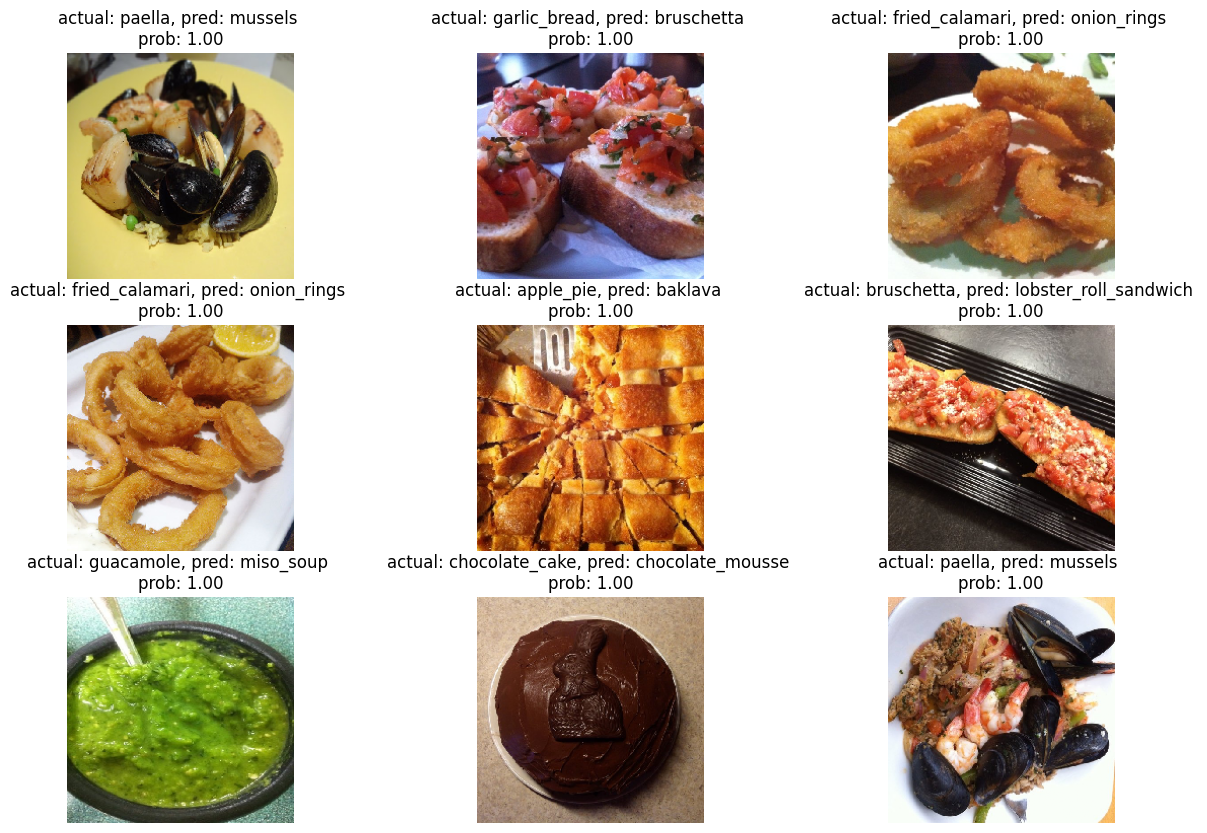

In [58]:
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)


In [59]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-06-26 10:24:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  14.9MB/s    in 0.8s    

2024-06-26 10:24:43 (14.9 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [60]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 65ms/step


TypeError: unsupported operand type(s) for /: 'Image' and 'float'

<Figure size 640x480 with 0 Axes>

In [62]:

import matplotlib.pyplot as plt
import tensorflow as tf

# Define your load_and_prep_image function
def load_and_prep_image(filepath, scale=True):
    # Load image from filepath
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=(224, 224))

    # Optionally scale pixel values to [0, 1]
    if scale:
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    return img

# Example list of custom food images (replace with your actual list)
custom_food_images = ['path/to/image1.jpg', 'path/to/image2.jpg', 'path/to/image3.jpg']

# Example function to process each image and plot
for img_path in custom_food_images:
    try:
        # Load and preprocess the image
        img = load_and_prep_image(img_path, scale=False)

        # Make predictions
        pred_prob = model.predict(tf.expand_dims(img, axis=0))  # Model accepts tensors of shape [None, 224, 224, 3]
        pred_class = class_names[pred_prob.argmax()]  # Find the predicted class label

        # Plot the image with appropriate annotations
        plt.figure()
        plt.imshow(img / 255.)
        plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
        plt.axis(False)
        plt.show()  # Display the plot for each image

    except Exception as e:
        print(f"Error processing image {img_path}: {e}")


Error processing image path/to/image1.jpg: [Errno 2] No such file or directory: 'path/to/image1.jpg'
Error processing image path/to/image2.jpg: [Errno 2] No such file or directory: 'path/to/image2.jpg'
Error processing image path/to/image3.jpg: [Errno 2] No such file or directory: 'path/to/image3.jpg'
